In [1]:
library(tidyverse)
library(broom)
library(tableone)
library(ggplot2)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'tableone' was built under R version 4.4.3"


In [2]:
data <- read_csv("data_donnees_2021_ind_v2.csv")

head(data)
dim(data)

Rows: 980868 Columns: 144
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (144): PPSORT, ABOID, AGEGRP, AGEIMM, ATTSCH, BFNMEMB, BedRm, CFInc, CFI...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


PPSORT,ABOID,AGEGRP,AGEIMM,ATTSCH,BFNMEMB,BedRm,CFInc,CFInc_AT,CFSTAT,⋯,WT7,WT8,WT9,WT10,WT11,WT12,WT13,WT14,WT15,WT16
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,13,7,1,0,4,30,27,2,⋯,22.90113,22.90113,22.90113,249.27876,22.90113,22.90113,22.90113,22.90113,22.90113,22.90113
2,6,11,5,1,0,3,18,18,2,⋯,22.89379,22.89379,22.89379,22.89379,22.89379,22.89379,22.89379,22.89379,22.89379,22.89379
3,1,13,99,1,0,0,7,7,6,⋯,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134
4,6,16,99,1,0,4,15,15,2,⋯,22.87713,22.87713,22.87713,22.87713,22.87713,22.87713,22.87713,22.87713,22.87713,22.87713
5,6,18,99,1,0,3,13,13,3,⋯,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134,22.90134
6,2,16,99,1,0,4,1,1,7,⋯,22.89284,22.89284,22.89284,22.89284,22.89284,22.89284,22.89284,249.18847,22.89284,22.89284


[1] 980868    144

# data processing

In [3]:
data <- data %>%
  mutate(
    post = ifelse(AGEGRP >= 17, 1, 0),  # AGEGRP 17+ corresponds to age 65+, so post = 1
    treat = case_when(
      IMMSTAT == 1 & HHInc_AT %in% 1:22 ~ 1,     # Canadian-born and income after tax < $90k -> eligible
      IMMSTAT == 1 & HHInc_AT >= 23 ~ 0,         # Canadian-born nd income after tax >= $90k -> ineligible
      IMMSTAT == 2 & AGEIMM <= 11 ~ 1,           # Immigrated before age 55 -> eligible
      IMMSTAT == 2 & AGEIMM > 11 ~ 0,            # Immigrated at or after age 55 -> ineligible 
      IMMSTAT == 3 ~ NA_real_,                   # Non-permanent residents -> drop
      AGEIMM %in% c(88, 99) ~ NA_real_           # Invalid age at immigration -> drop
    )
  )

In [4]:
data_clean <- data %>%
  filter(
    AGEGRP %in% c(16, 17),     # Age 60–69
    IMMSTAT %in% c(1, 2),
    LFACT %in% 1:14,
    !is.na(LFACT),                   
    !is.na(Gender),
    !is.na(HDGREE),
    !is.na(EfDIMBM_2018),
    !is.na(post),
    !is.na(HHInc_AT), #try
    !is.na(treat)                   
  ) %>%
   mutate(
    labour_force = ifelse(LFACT %in% 1:10, 1, 0),      
    Gender = factor(Gender),
    HDGREE = factor(HDGREE),
    HHInc_AT = factor(HHInc_AT), #try
    EfDIMBM_2018 = factor(EfDIMBM_2018))

In [5]:
table(data_clean$post, data_clean$treat)

   
        0     1
  0 21810 46121
  1 15148 42990

# modeling

In [6]:
model_dd_glm <- glm(
  labour_force ~ post * treat + Gender + HDGREE + EfDIMBM_2018 + HHInc_AT,
  data = data_clean,
  family = binomial
)

summary(model_dd_glm)


Call:
glm(formula = labour_force ~ post * treat + Gender + HDGREE + 
    EfDIMBM_2018 + HHInc_AT, family = binomial, data = data_clean)

Coefficients: (1 not defined because of singularities)
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -1.016746   0.102163  -9.952  < 2e-16 ***
post           -1.044434   0.022500 -46.419  < 2e-16 ***
treat           0.283870   0.023674  11.991  < 2e-16 ***
Gender2         0.508088   0.012637  40.208  < 2e-16 ***
HDGREE2         0.262472   0.019546  13.429  < 2e-16 ***
HDGREE3         0.401360   0.030458  13.177  < 2e-16 ***
HDGREE4         0.292814   0.032508   9.007  < 2e-16 ***
HDGREE5         0.402006   0.035282  11.394  < 2e-16 ***
HDGREE6         0.420409   0.025764  16.318  < 2e-16 ***
HDGREE7         0.290664   0.028233  10.295  < 2e-16 ***
HDGREE8         0.444810   0.038502  11.553  < 2e-16 ***
HDGREE9         0.341435   0.023408  14.586  < 2e-16 ***
HDGREE10        0.373495   0.052436   7.123 1.06e-12 ***
HDGREE11 

# visualization

## common trend

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


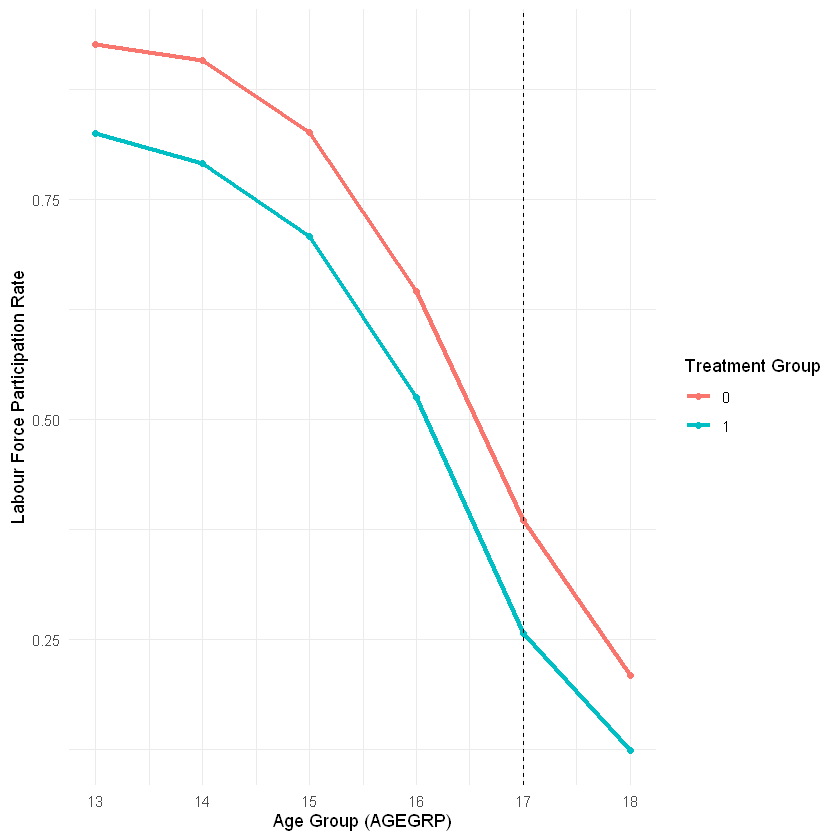

In [7]:
pre_data <- data %>%
  filter(AGEGRP %in% c(13,14,15,16,17,18)) %>%
  mutate(
    labour_force = ifelse(LFACT %in% 1:10, 1, 0),
    treat = case_when(
      IMMSTAT == 1 & HHInc_AT %in% 1:22 ~ 1,      
      IMMSTAT == 1 & HHInc_AT >= 23 ~ 0,
      IMMSTAT == 2 & AGEIMM <= 11 ~ 1,
      IMMSTAT == 2 & AGEIMM > 11 ~ 0,
      IMMSTAT == 3 ~ NA_real_,
      AGEIMM %in% c(88, 99) ~ NA_real_
    )
  ) %>%
  filter(IMMSTAT %in% c(1,2), !is.na(treat), !is.na(labour_force)) %>%
  group_by(AGEGRP, treat) %>%
  summarise(lfp_rate = mean(labour_force), .groups = "drop")

# plot
library(ggplot2)

ggplot(pre_data, aes(x = AGEGRP, y = lfp_rate, color = factor(treat))) +
  geom_line(size = 1.2) +
  geom_point() +
  geom_vline(xintercept = 17, linetype = "dashed", color = "black") +
  labs(
    x = "Age Group (AGEGRP)",
    y = "Labour Force Participation Rate",
    color = "Treatment Group"
  ) +
  theme_minimal()


# post bar

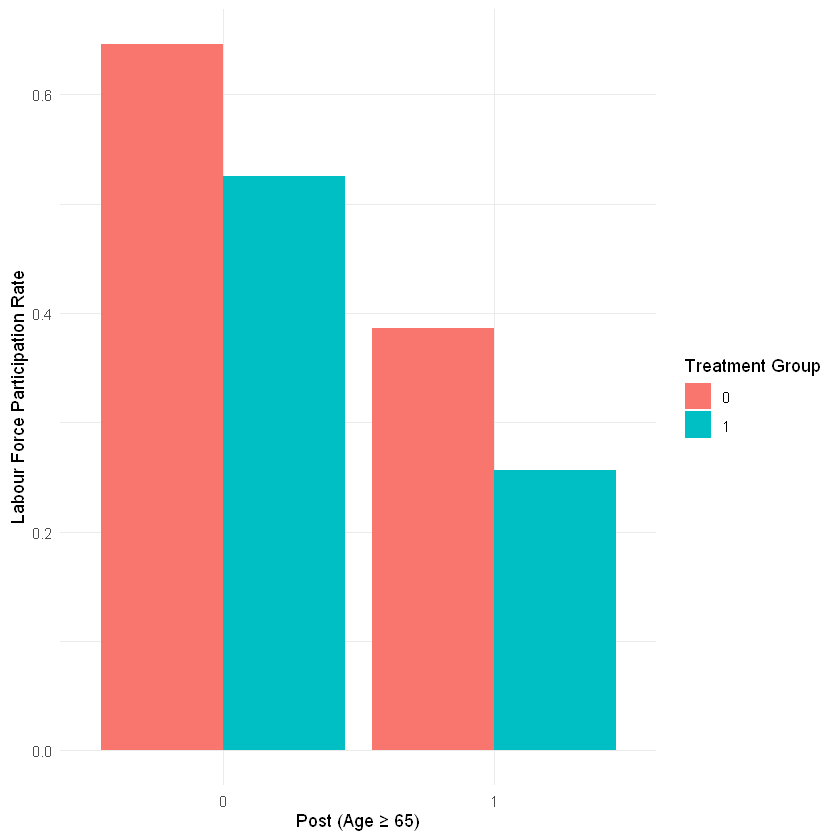

In [8]:
ggplot(data_clean, aes(x = factor(post), y = labour_force, fill = factor(treat))) +
  stat_summary(fun = mean, geom = "bar", position = "dodge") +
  labs(
    x = "Post (Age ≥ 65)",
    y = "Labour Force Participation Rate",
    fill = "Treatment Group"
  ) +
  theme_minimal()
